# DRC Roads Temporal Analysis

In this notebook we focus on identification of change through classification of a temporal stack of images covering the Area of Interest (AOI). We utilize the algorithm for classifying imagery into forest / non-forest developed in [drc_roads_classification](drc_roads_classification.ipynb) to classify the imagery into forest/non-forest. Then, we utilize random forests to identify and classify change in the temporal stack.

Keywords: temporal analysis, forest monitoring, classification

In [1]:
import datetime
from functools import reduce
import json
import os

import numpy as np
import pandas as pd
from planet import api
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Import functionality from local notebooks
from ipynb.fs.defs.drc_roads_download import get_overlapping_scenes, StripDownloader, StripSearcher
from ipynb.fs.defs.drc_roads_classification \
    import Timer, load_training_data, classify_forest, classified_band_to_rgb

## Download Scenes

In this section, we use the ipynb module to import `StripDownloader` from the [drc_roads_download](drc_roads_download.ipynb) notebook. We then use `StripDownloader` to download the portion of OrthoTile strips that overlap the AOI.

### Load data from drc_roads_download notebook

In [3]:
# load aoi. Saved in drc_roads_download notebook
aoi_geojson_filename = os.path.join('pre-data', 'aoi.geojson')

### Download portions of OrthoTile strips that overlap AOI

In [4]:
# create planet api client
planet_api_key = os.environ['PL_API_KEY']

# quick check that key is defined
assert planet_api_key, "PL_API_KEY not defined."

client = api.ClientV1(api_key=planet_api_key)

In [5]:
# load aoi json
with open(aoi_geojson_filename) as json_data:
    aoi = json.load(json_data)

In [6]:
# get good overlapping scenes from to July 2017 to February 2018
begin=datetime.datetime(year=2017,month=7,day=1)
end=datetime.datetime(year=2018,month=3,day=1)
strip_searcher = StripSearcher(aoi, begin, end, client)
good_scenes = strip_searcher.search(aoi_geojson_filename)

500 OrthoTiles were returned from the api search.
There are 494 OrthoTiles that overlap aoi.
There are 144 OrthoTiles in 36 strips that significantly overlap the aoi.
36 strips
found data/1214499_udm_mosaic.tif
found data/1176905_udm_mosaic.tif
found data/1167439_udm_mosaic.tif
found data/1153620_udm_mosaic.tif
found data/1150329_udm_mosaic.tif
found data/1130991_udm_mosaic.tif
found data/1127986_udm_mosaic.tif
found data/1124454_udm_mosaic.tif
found data/1121892_udm_mosaic.tif
found data/1114901_udm_mosaic.tif
found data/1043874_udm_mosaic.tif
found data/1091588_udm_mosaic.tif
found data/1085449_udm_mosaic.tif
found data/1081381_udm_mosaic.tif
found data/1054596_udm_mosaic.tif
found data/1047845_udm_mosaic.tif
found data/1043827_udm_mosaic.tif
found data/1037433_udm_mosaic.tif
found data/1011123_udm_mosaic.tif
found data/993122_udm_mosaic.tif
found data/960830_udm_mosaic.tif
found data/943459_udm_mosaic.tif
found data/904538_udm_mosaic.tif
found data/915538_udm_mosaic.tif
found data/8

In [8]:
asset_type = 'analytic'
strip_downloader = StripDownloader(good_scenes, aoi_geojson_filename, client)
strip_downloader.run(asset_type, overwrite=False, verbose=True)

21 strips
found data/1176905_analytic_mosaic.tif
found data/1153620_analytic_mosaic.tif
found data/1130991_analytic_mosaic.tif
found data/1127986_analytic_mosaic.tif
found data/1124454_analytic_mosaic.tif
found data/1121892_analytic_mosaic.tif
found data/1114901_analytic_mosaic.tif
found data/1091588_analytic_mosaic.tif
found data/1085449_analytic_mosaic.tif
found data/1081381_analytic_mosaic.tif
found data/1047845_analytic_mosaic.tif
found data/1043827_analytic_mosaic.tif
found data/1037433_analytic_mosaic.tif
found data/943459_analytic_mosaic.tif
found data/758681_analytic_mosaic.tif
found data/741529_analytic_mosaic.tif
found data/739199_analytic_mosaic.tif
found data/699281_analytic_mosaic.tif
found data/651530_analytic_mosaic.tif
found data/666617_analytic_mosaic.tif
found data/636659_analytic_mosaic.tif
Nothing to download


### Get mosaic image names

In [9]:
# sort strip ids as integers. Strip id order is the same as strip temporal order
strip_ids = [int(s) for s in good_scenes.strip_id.unique().tolist()]
strip_ids.sort()
strip_ids = [str(s) for s in strip_ids]

In [10]:
strip_mosaics = [strip_downloader.get_filename(i, asset_type) for i in strip_ids]

In [179]:
# strip_mosaics

## Classify Scenes

In this section, we use the ipynb module to import classification functionality from the [drc_roads_classification](drc_roads_classification.ipynb) notebook.

In [91]:
classified_bands_file = os.path.join('data', 'classified_bands.npz')

def save_to_cache(classified_bands, strip_ids):
    save_bands = dict((s, classified_bands[s])
                      for s in strip_ids)
    # masked arrays are saved as just arrays, so save mask for later
    save_bands.update(dict((s+'_msk', classified_bands[s].mask)
                           for s in strip_ids))
    np.savez_compressed(classified_bands_file, **save_bands)  

def load_from_cache():
    tmp_cls = np.load(classified_bands_file)
    sids = [k for k in tmp_cls.keys() if not k.endswith('_msk')]
    # reform masked array from saved array and saved mask
    classified_bands = dict((s, np.ma.array(tmp_cls[s], mask=tmp_cls[s+'_msk']))
                            for s in sids)
    return classified_bands

In [92]:
save_to_cache(classified_bands, strip_ids)

In [93]:
use_cache = True

if use_cache and os.path.isfile(classified_bands_file):
    print('using cached classified bands')
    test_classified_bands = load_from_cache()
else:
    X_training, y_training = load_training_data()
    with Timer():
        def classify(sid):
            img = strip_downloader.get_filename(sid, asset_type)
            # we only have two values, 0 and 1. Convert to uint8 for memory
            band = (classify_forest(img, X_training, y_training)).astype(np.uint8)
            return band

        classified_bands = dict((s, classify(s)) for s in strip_ids)
    
    # save to cache
    save_to_cache(classified_bands, strip_ids)

using cached classified bands


### Visualize Classified Scenes

In [94]:
# load local visual module
# autoreload because visual is in development

%load_ext autoreload
%autoreload 2

import visual

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


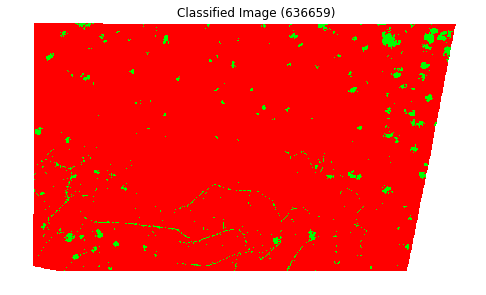

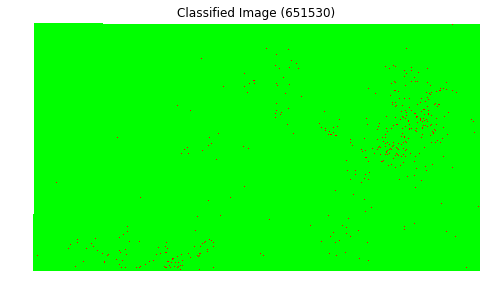

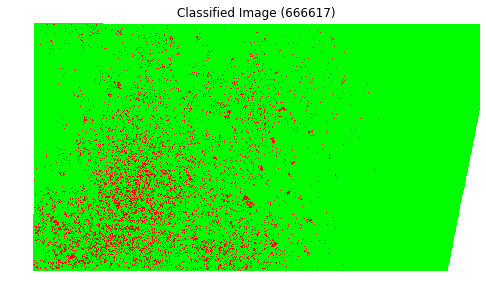

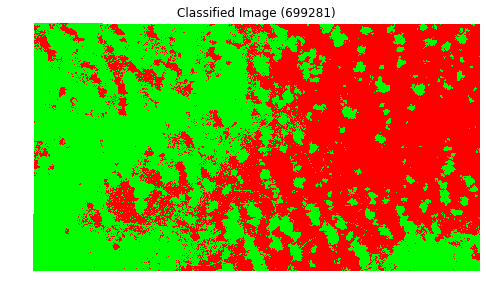

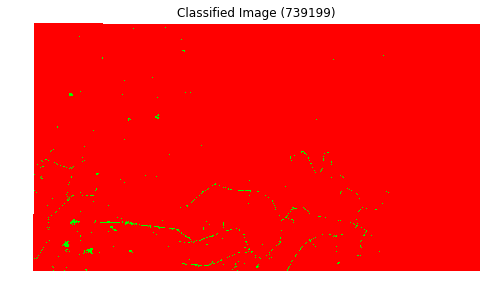

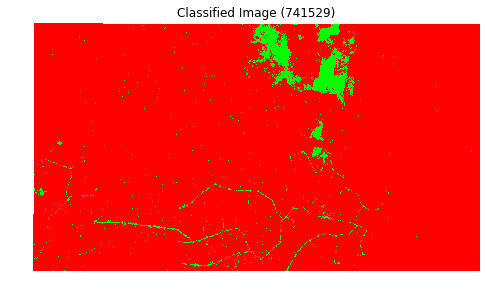

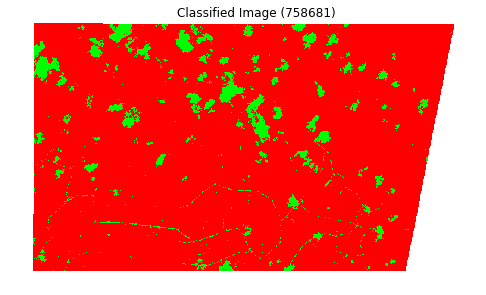

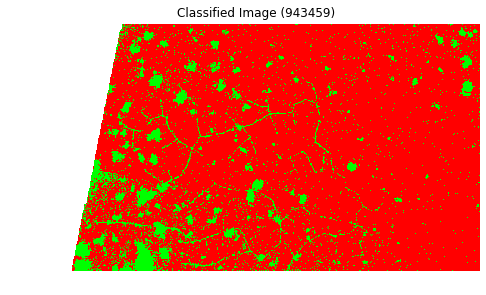

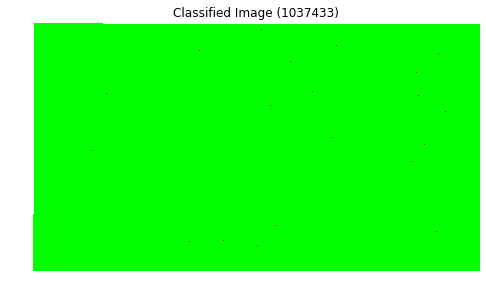

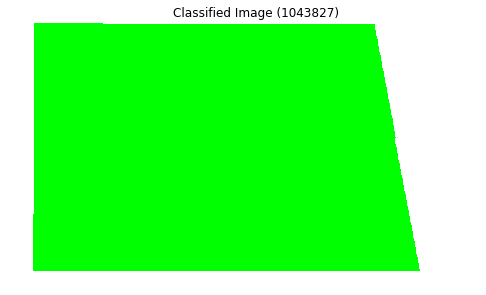

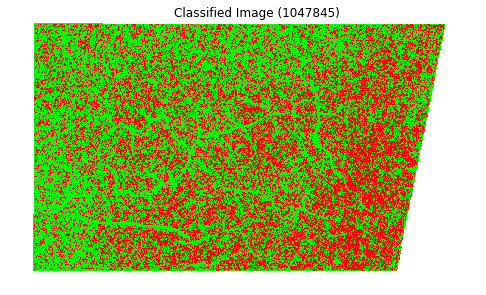

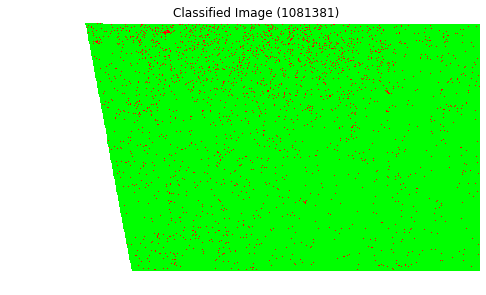

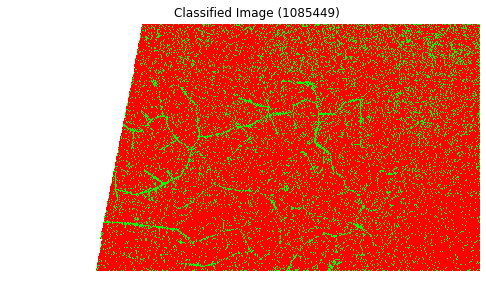

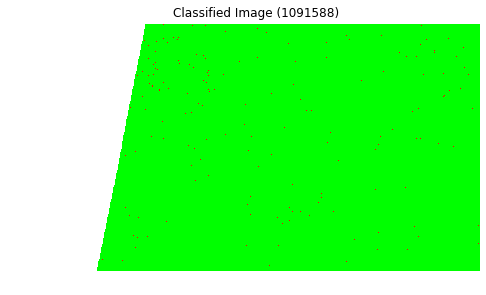

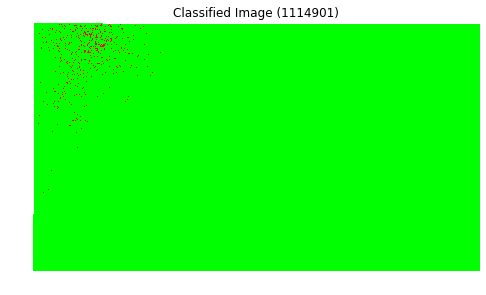

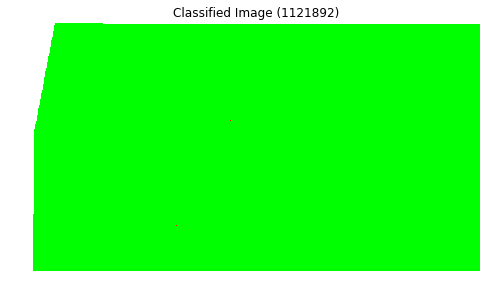

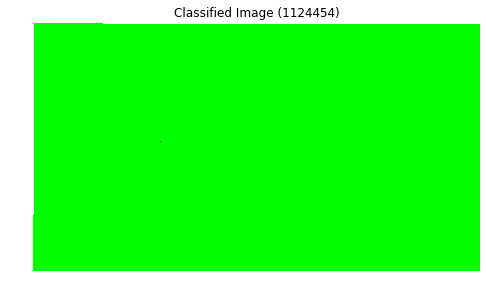

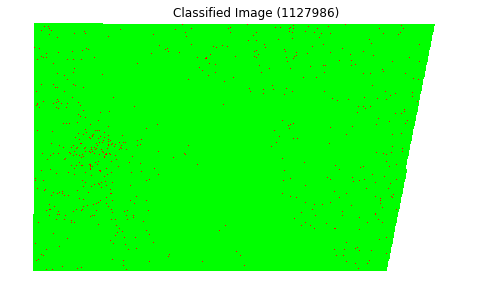

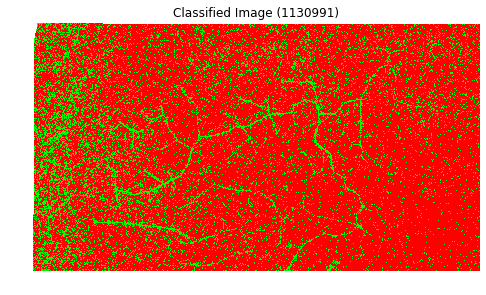

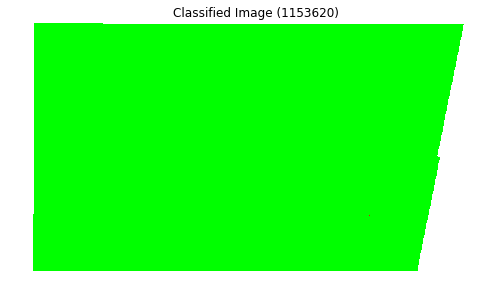

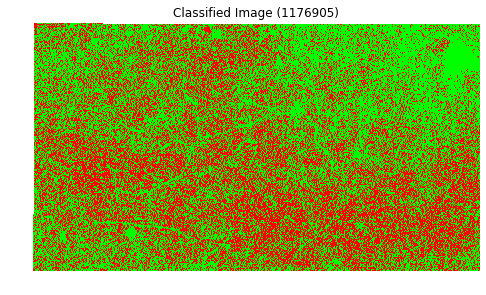

In [180]:
# Decimate classified arrays for memory conservation
def decimate(arry, num=8):
    return arry[::num, ::num].copy()

do_visualize = True # set to True to view images
if do_visualize:
    for strip_id, classified_band in test_classified_bands.items():
        visual.plot_image(classified_band_to_rgb(decimate(classified_band)),
                          title='Classified Image ({})'.format(strip_id),
                          figsize=(8, 8))

The results of classification in these images is mixed. There are a few images where the UDM fails to identify clouds (e.g. 1114901) and few images where the results actually look pretty good but classification missfires and classifies everything as non-forest (e.g. 1091588). There may be uniform in the imagery that makes it brighter than usual, which causes the classifier to fail. Ultimately, visual inspection finds that about 8 of the 21 classified images looks informative.

## KMeans Classification

First, we will perform KMeans (unsupervised) classification of the pixels into two classes.

In [215]:
def get_bands(classified_bands):
    return [classified_bands[k] for k in classified_bands.keys()]

def perc_masked(mask):
    return 100*(np.count_nonzero(mask))/mask.size

def num_valid(mask):
    return (mask.size - np.count_nonzero(mask))

def combine_masks(classified_bands):
    masks = [b.mask for b in get_bands(classified_bands)]
    total_mask = reduce(np.logical_or, masks)
    print('{} valid pixels ({}% masked)'.format(num_valid(total_mask), round(perc_masked(total_mask), 2)))
    return total_mask

def valid_pixels(band, mask):
    masked_band = np.ma.array(band, mask=mask)
    return masked_band.compressed()
    
def bands_to_X(classified_bands, mask):
    # X shape: (num_pixels, num_bands)
    all_valid_pixels = [valid_pixels(b, mask) for b in get_bands(classified_bands)]
    X = np.swapaxes(np.stack(all_valid_pixels), 0, 1)
    return X

# lets just work with pixels that have a data point in every image
total_mask = combine_masks(classified_bands)
X = bands_to_X(classified_bands, total_mask)

11802646 valid pixels (41.06% masked)


In [216]:
def classify_kmeans(X):
    mbk = MiniBatchKMeans(n_clusters=2)
    
    with Timer():
        mbk.fit(X)
        
    with Timer():
        y_pred = mbk.predict(X)
        
    return y_pred

y_pred = classify_kmeans(X)

41 seconds
39 seconds


In [217]:
def y_to_band(y, mask):
    band = np.ma.array(np.zeros(mask.shape), mask=mask)
    band[~band.mask] = y
    return band

y_band = y_to_band(y_pred, total_mask)
print(y_band.shape)
print(y_band.size - np.count_nonzero(y_band.mask))
print(np.count_nonzero(y_band))

(3333, 6008)
11802646
6002410


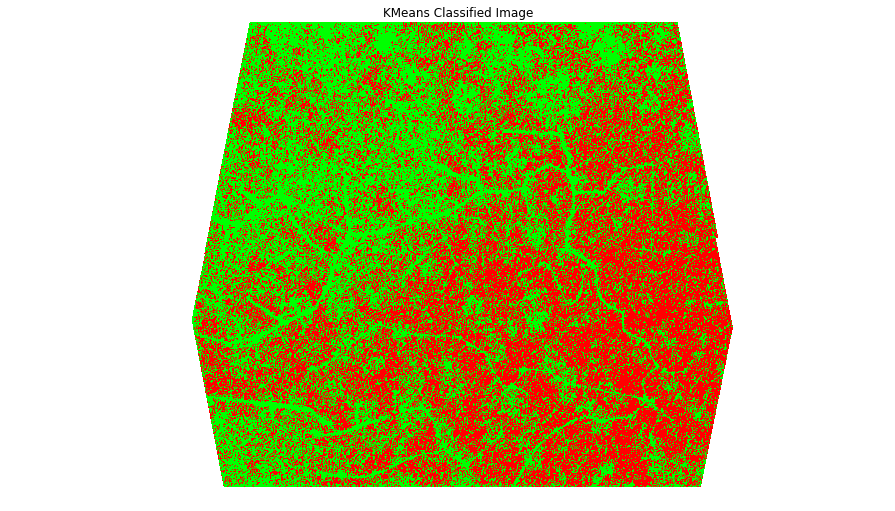

In [218]:
# separate the class numbers into rgb bands
def classified_band_to_rgb(classified_band):
    return [classified_band == n for n in [0,1,2]]

visual.plot_image(classified_band_to_rgb(y_band), title='KMeans Classified Image', figsize=(15, 15))

Ok. We can kind of see roads here, but the new roads (aka the change) isn't clearly identified. Let's try supervised classification.

## Supervised Classification

### Prepare and save image for labeling

We will perform labeling in GIMP. We really want to highlight the changes in roads, so we will look at the difference between two high-quality classified images.

The images we will use are `739199` for before and `1130991` for after.

In [172]:
label_band = abs(classified_bands['1130991'] - classified_bands['739199'])

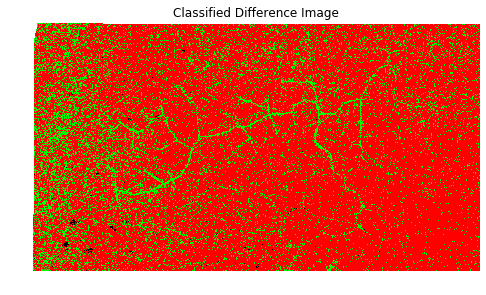

In [173]:
visual.plot_image(classified_band_to_rgb(decimate(label_band)),
                          title='Classified Difference Image',
                          figsize=(8, 8))

In [174]:
# set nodata to zero, move class values to 1 and 2
label_band_array = (label_band + 1).filled(0)

In [186]:
label_img = os.path.join('data', 'difference.tif')

(height, width) = label_band_array.shape
profile = {
    'width': width,
    'height': height,
    'driver': 'GTiff',
    'count': 1,
    'compress': 'lzw',
    'dtype': rasterio.uint8
    }

with rasterio.open(label_img, 'w', **profile) as dst:
    # multiply by 100 for visibility
    dst.write(100 * label_band_array.astype(rasterio.uint8), 1)

/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:253: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  **kwargs)


### Create Label Masks from Label Images

The labeled images were created in [GIMP](https://www.gimp.org/) using manual labeling of change (roads being built).

In [194]:
change_img = os.path.join('pre-data', 'difference_change.tif')
nochange_img = os.path.join('pre-data', 'difference_nochange.tif')

In [197]:
def get_label_mask(image_filename):
    with rasterio.open(image_filename, 'r') as src:
        band = src.read(1)
        label_data = band == 255 # valid data in white regions
        label_mask = ~label_data # mask True (masked) for not valid data
    return label_mask

def get_unmasked_count(mask):
    return np.size(mask) - np.count_nonzero(mask)

change_mask = get_label_mask(change_img)
print(get_unmasked_count(change_mask))
nochange_mask = get_label_mask(nochange_img)
print(get_unmasked_count(nochange_mask))

225809
7765921


/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:240: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  s = DatasetReader(fp, driver=driver, **kwargs)


### Get Features from Labels

In [207]:
# combine the label masks with the valid data mask and then create X dataset for each label
total_mask = combine_masks(classified_bands)
total_change_mask = np.logical_or(total_mask, change_mask)
print('{} valid pixels ({}% masked)'.format(num_valid(total_change_mask),
                                            round(perc_masked(total_change_mask), 2)))
X_change = bands_to_X(classified_bands, total_change_mask)

total_nochange_mask = np.logical_or(total_mask, nochange_mask)
print('{} valid pixels ({}% masked)'.format(num_valid(total_nochange_mask),
                                            round(perc_masked(total_nochange_mask), 2)))
X_nochange = bands_to_X(classified_bands, total_nochange_mask)

11802646 valid pixels (41.06% masked)
200962 valid pixels (99.0% masked)
3125810 valid pixels (84.39% masked)


In [235]:
def sample_pixels(pixels, sample_size):
    if pixels.shape[0] > sample_size:
        pixel_sample = pixels.copy()
        np.random.shuffle(pixel_sample)
        pixel_sample = pixel_sample[:sample_size]
    else:
        pixel_sample = pixels
    return pixel_sample
    
def make_same_size_samples(list_of_X, size_percent=100):
    # X: array of dim (num_pixels, num_classified_bands)
    sample_len = min([p.shape[0] for p in list_of_X])

    # only return size_percent number of pixels in the sample
    if size_percent < 100 and size_percent > 0:
        sample_len = round(sample_len * size_percent/100.0)
    
    return [sample_pixels(p, sample_len) for p in list_of_X]

[X_change_sample, X_nochange_sample] = \
    make_same_size_samples([X_change, X_nochange], size_percent=10)

print(X_change_sample.shape)
print(X_nochange_sample.shape)

(20096, 21)
(20096, 21)


In [236]:
change_label_value = 0
nochange_label_value = 1
X_rf = np.concatenate((X_change_sample, X_nochange_sample), axis=0)
y_rf = np.array(X_change_sample.shape[0] * [change_label_value] + \
                X_nochange_sample.shape[0] * [nochange_label_value])
    
print(X_rf.shape)
print(y_rf.shape)

(40192, 21)
(40192,)


### Classify

In [238]:
def classify_change(classified_bands, mask, X_training, y_training):
    clf = RandomForestClassifier()
    
    with Timer():
        clf.fit(X_training, y_training)
    
    X = bands_to_X(classified_bands, total_mask)
    
    with Timer():
        y_pred = clf.predict(X)

    y_band = y_to_band(y_pred, total_mask)
    return y_band

with Timer():
    y_band_rf = classify_change(classified_bands, total_mask, X_rf, y_rf)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
8 seconds
10 seconds


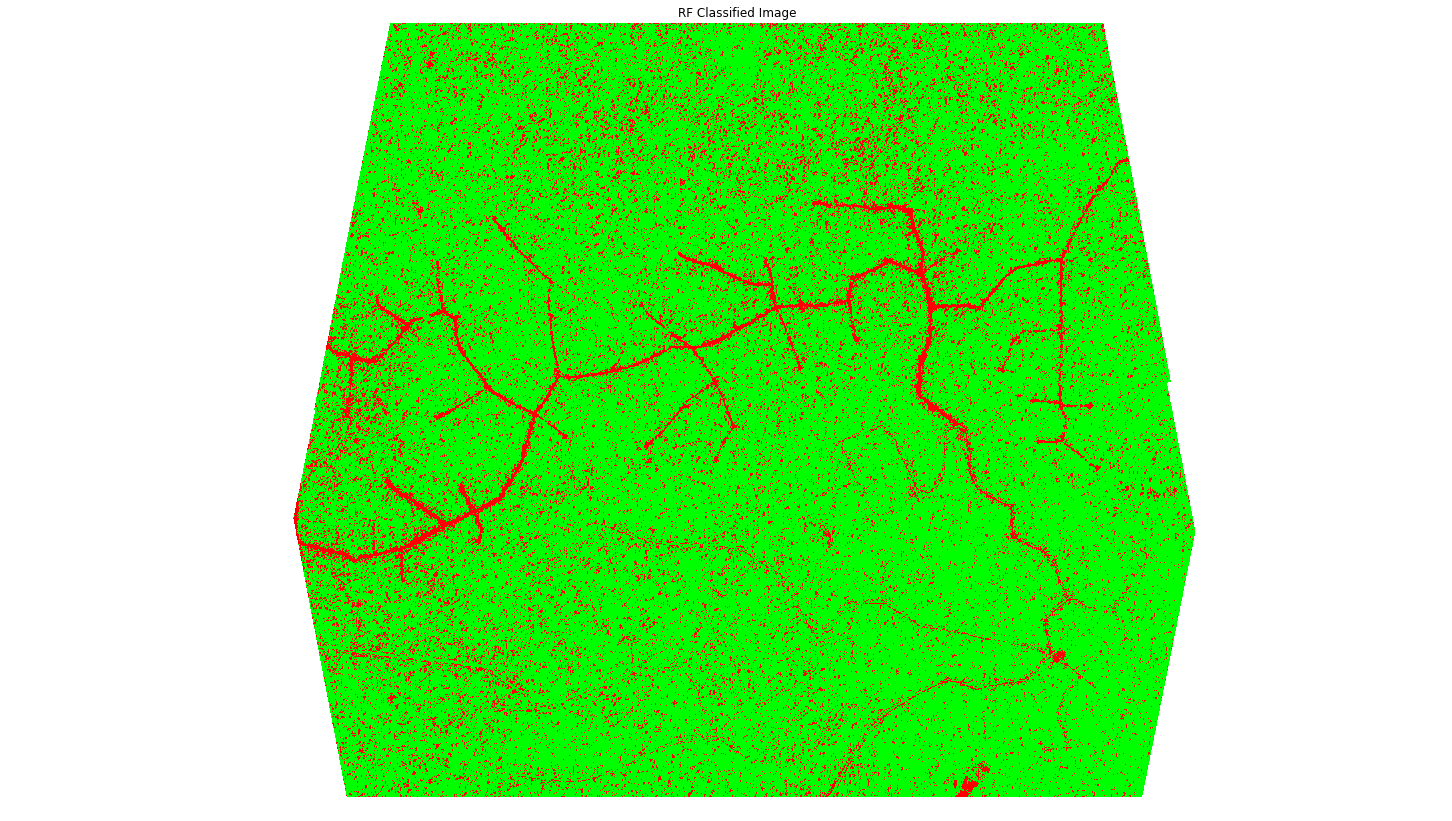

In [239]:
visual.plot_image(classified_band_to_rgb(y_band_rf), title='RF Classified Image', figsize=(25, 25))

The results look pretty good! With a little clean up, we could have a pretty cut and dry change classification. To achieve these results, we used only 10% of the pixels manually labeled as 'change' as the training dataset.